In [67]:
# based on exmaples from
# https://planetarycomputer.microsoft.com/docs/tutorials/cloudless-mosaic-sentinel2/
# https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer
import glob
import rioxarray
from rioxarray.merge import merge_arrays
import re
import datetime
import pandas as pd
from shapely.geometry import box
import odc.stac
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import rasterio as rio

In [99]:
def cop30_for_aso(aso_raster_fn):
    aso_raster = rxr.open_rasterio(aso_raster_fn).squeeze()
    aso_raster = aso_raster.where(aso_raster>=0, drop=True)
    aso_raster = aso_raster.interpolate_na(dim='x')
    bounds_latlon = box(*aso_raster.rio.transform_bounds("EPSG:4326"))
    
    catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace)

    search = catalog.search(
        collections=["cop-dem-glo-30"],
        intersects=bounds_latlon)

    # Check how many items were returned
    items = search.item_collection()
    print(f"Returned {len(items)} Items")
    
    data = []
    for item in items:
        dem_path = planetary_computer.sign(item.assets['data']).href
        data.append(rxr.open_rasterio(dem_path))
    cop30_da = merge_arrays(data)  
    
    # clip to ASO extent
    cop30_da = cop30_da.squeeze().rio.reproject_match(aso_raster)
    
    #cop30_da.to_netcdf(f'../data/cop30/cop30_for_{aso_raster_fn.split("/")[-1][:-4]}.nc')
    
    #return cop30_da, aso_raster

In [75]:
# fn = '/home/jovyan/crunchy-snow/data/ASO/ASO_50m_SD_cleaned/utm10n/ASO_50M_SD_SacramentoMcCloud_20230209_clean.tif'

In [100]:
# cop30_da, aso = cop30_for_aso(fn)

Returned 4 Items


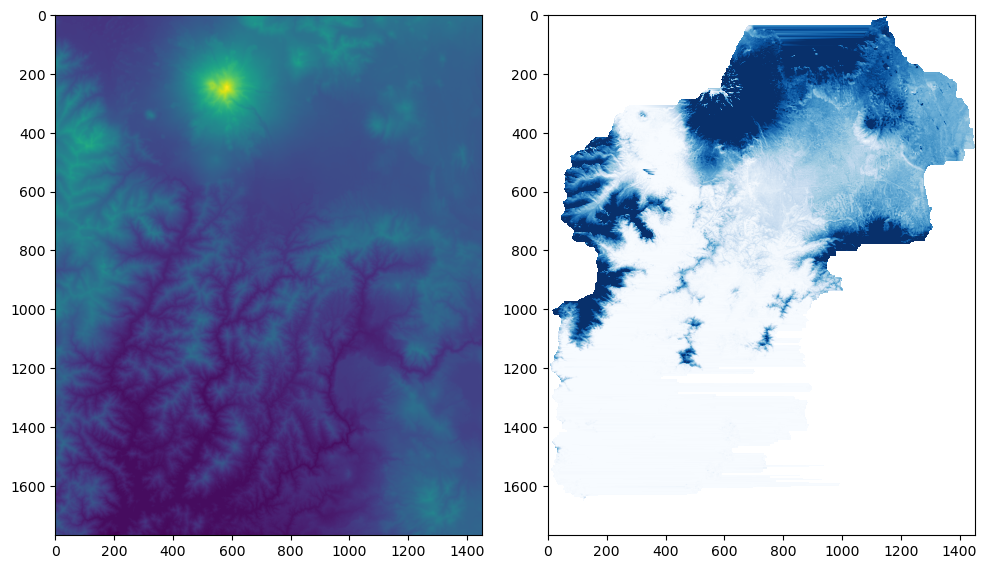

In [103]:
# f, ax = plt.subplots(1, 2, figsize = (10, 10))
# ax[0].imshow(cop30_da)
# ax[0].set_aspect('equal')
# ax[1].imshow(aso, vmin=0, vmax=2, cmap = "Blues")
# ax[1].set_aspect('equal')
# plt.tight_layout()

In [ ]:
def cop30_for_aso_all(dir_path):
    raster_paths = glob.glob(f'{dir_path}/*/ASO_50M_SD*.tif')
    for i, path in enumerate(raster_paths):
        print(f'----\nworking on {path.split("/")[-1]}, {i+1}/{len(raster_paths)}\n----')
        
        cop30_for_aso(path)